In [1]:
import argparse
import random

import numpy as np
import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info
import umap
from sklearn.datasets import make_swiss_roll,make_s_curve
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from sklearn.neighbors import kneighbors_graph,radius_neighbors_graph
from sklearn.decomposition import PCA
from sklearn import manifold
import dynamo

CHECKPOINT_PREFIX = "g2g"
from scipy.sparse import csr_matrix

from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds

In [2]:
# result_dir='/home/dell/Desktop/cpt_manifold/results/'
result_dir='results/'

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters of the simulation
k1 = 0.05  
k2= 0.05
shift=0
amp=0.5

D=1.0
dt = 0.01  # Time step
tmax = 10000.0  # Maximum simulation time
x0 = np.array([0.0, 0.0])  # Initial position

# Define the double well potential
def potential(x,k1,k2,shift):
    return amp*(k1*x[0]**4-x[0]**2+k2*x[1]**4-(x[1]-shift)**2)

# Define the gradient of the potential
def gradient(x,k1,k2,shift):
    return amp*np.array([4*k1*x[0]**3-2*x[0],4*k2*x[1]**3-2*x[1]+shift*2])

# Define the stochastic force
def stochastic_force(x,D):
    return np.sqrt(2.0 * D ) * np.random.normal(size=2)

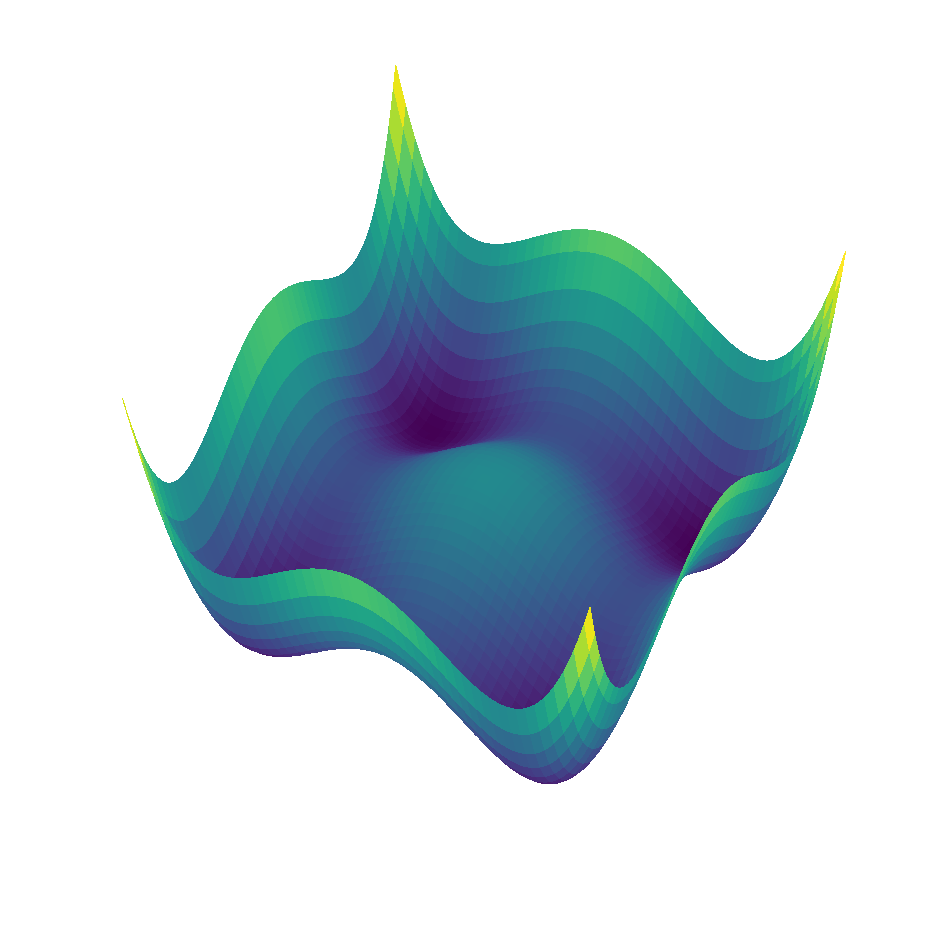

In [143]:
#### import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the double well potential function
# def four_well_potential(x, y):
#     return 0.05*x**4-x**2+0.05*y**4-(y-0)**2

# Define the range of x and y values to plot


x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

# Create a 2D grid of x and y values
xx, yy = np.meshgrid(x, y)

# Calculate the potential energy at each point in the grid
U = potential([xx, yy],k1,k2,shift)

# Create a 3D surface plot of the potential energy
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, U, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel("X",fontsize=16)
ax.set_ylabel("Y",fontsize=16)
ax.set_zlabel("U",fontsize=16)
ax.set_axis_off()

ax.view_init(elev=50,roll=0)#, azim=40, 

plt.savefig(result_dir+'4well_U.png',dpi=600)
plt.show()

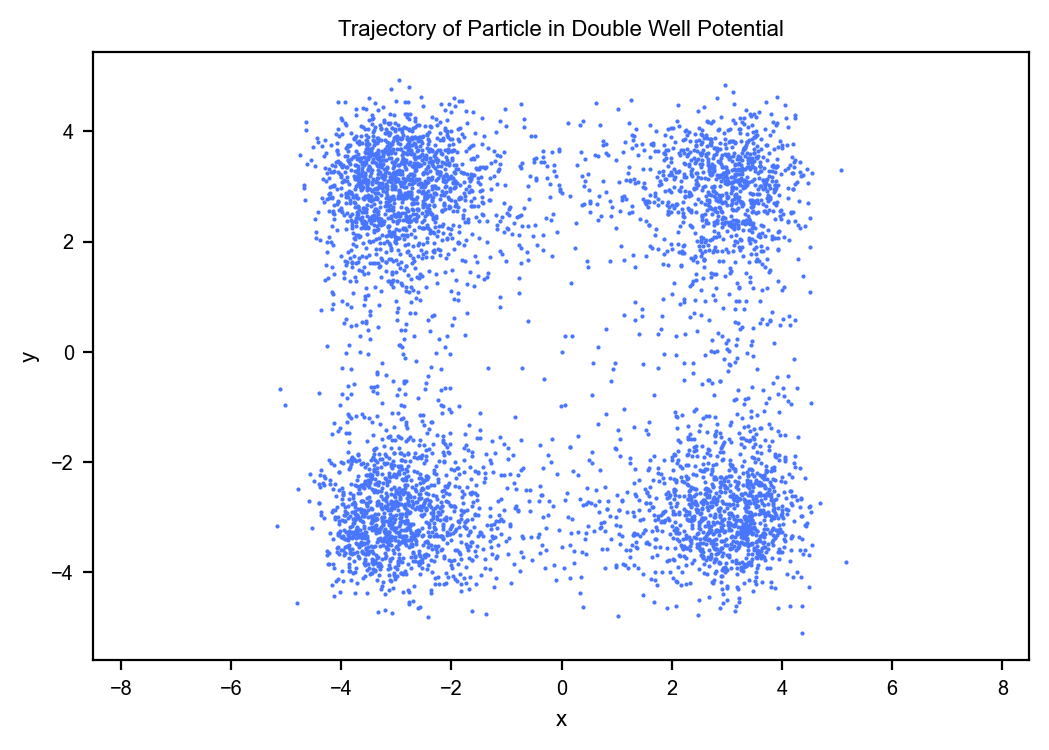

In [113]:
# Initialize the particle position and velocity


# Initialize the time and trajectory arrays

trajs=[]
traj_vs=[]
traj_m2s=[]
# x0=(np.random.rand(100,2)-0.5)*10
# print(x0)
x0=np.array([[0.,0.]])
for tl in range(1):
    # Perform the simulation using the Euler-Maruyama method
    
    x = x0[tl,:].copy()
    v = np.zeros(2)
    t = np.arange(0.0, tmax, dt)
    
    tr = np.zeros((len(t), 2))
    tr[0] = x
    
    tr_U= np.zeros((len(t), 1))
    tr_U[0]=potential(x,k1,k2,shift)
    
    tr_v= np.zeros((len(t), 2))
    tr_v[0]=v
    
    tr_Uv= np.zeros((len(t), 1))
    tr_Uv[0]=0
    
    tr_m2=np.zeros((len(t),2))


    for i in range(1, len(t)):
        # Calculate the deterministic force
        f_d = -gradient(x,k1,k2,shift)

        # Calculate the stochastic force
        f_s = stochastic_force(x,D)

        # Calculate the position using the Euler method
        x += (f_d*dt + f_s*np.sqrt(dt))

        # Update the trajectory array
        tr[i] = x
        tr_U[i] = potential(x,k1,k2,shift)
        tr_v[i]=f_d
        tr_Uv[i]=(tr_U[i]-tr_U[i-1])/dt

#     trajs.append(tr[::200,:])
    trajs.append(np.hstack((tr[::200, :],tr_U[::200,:])))
    traj_vs.append(np.hstack((tr_v[::200, :],tr_Uv[::200,:])))
    traj_m2s.append(tr_m2)
    # Plot the trajectory of the particle
    plt.scatter(tr[::200, 0], tr[::200, 1],s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('Trajectory of Particle in Double Well Potential')
plt.show()

In [114]:
X_major=np.concatenate(trajs,axis=0)
n_samples=X_major.shape[0]

X_minor=0.1*np.random.randn(n_samples,7)

X=np.hstack((X_major,X_minor))

color_label=np.zeros((n_samples))
color_label[np.argsort(X[:,0])]=np.arange(n_samples)
print(X.shape)

(5000, 10)


In [115]:
# n_samples=4000
# x_roi = np.linspace(-5, 5, 10000)
# y_roi = np.linspace(-5, 5, 10000)
# x1=np.random.choice(x_roi,n_samples)
# x2=np.random.choice(y_roi,n_samples)
# x3=four_well_potential(x1,x2)

# X_major=np.array([x1,x2,x3]).T


# X_minor=0.1*np.random.randn(X_major.shape[0],8)

# X=np.hstack((X_major,X_minor))

# n_samples=X.shape[0]
# color_label=np.zeros((n_samples))
# color_label[np.argsort(X[:,0])]=np.arange(n_samples)

In [116]:
k_nei=10
A = kneighbors_graph(X, k_nei, mode='connectivity', include_self=True)

In [117]:
row =np.array([np.ones((k_nei,))*i for i in range(X.shape[0])]).flatten()

col= np.array([np.where(A.getrow(i).toarray()[0,:])[0] for i in range(X.shape[0])]).flatten()

w_val=np.array([np.linalg.norm(X[int(i),:]-X[int(j),:]) for i,j in zip(row,col)])

adj_val=np.ones(col.shape)

A_mat=csr_matrix((adj_val, (row, col)), shape=(X.shape[0], X.shape[0]))

W_mat=csr_matrix((w_val, (row, col)), shape=(X.shape[0], X.shape[0]))

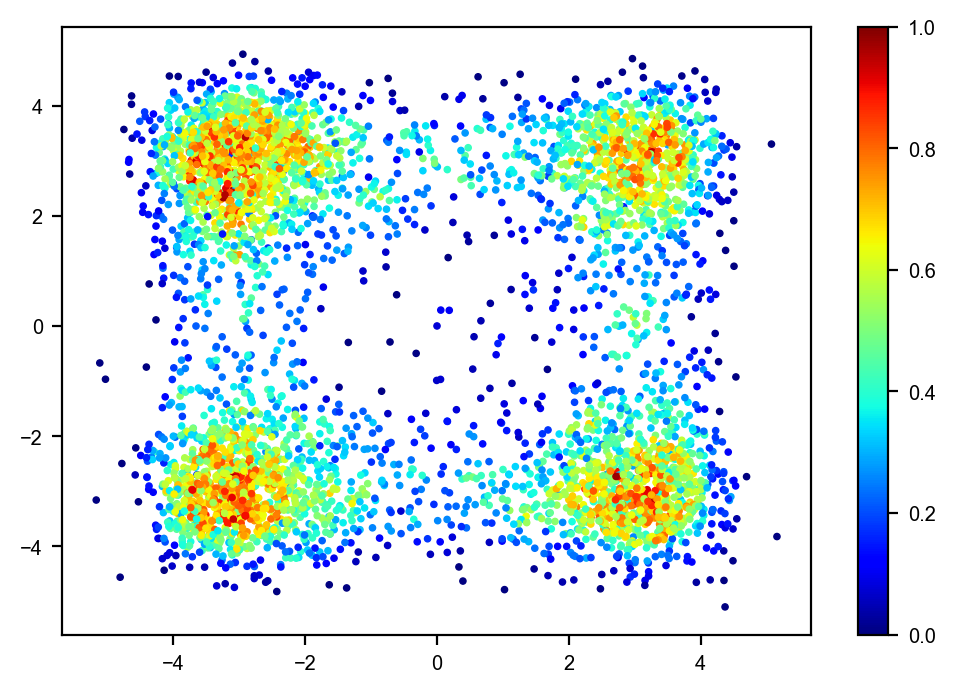

In [118]:
dc=np.mean(w_val)

cell_nei=A.indices.reshape(n_samples,k_nei).copy().copy().astype(np.int32)#np.array([np.where(A.getrow(i).toarray()[0,:])[0] for i in range(X.shape[0])]).astype(np.int32)
nei_w=[]
rho_arr=[]
for ni in cell_nei:
    dij=np.array([np.linalg.norm(X[int(ni[0]),:]-X[int(i),:]) for i in ni[1:]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2


plt.scatter(X[:,0],X[:,1],s=5,c=rho_arr,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

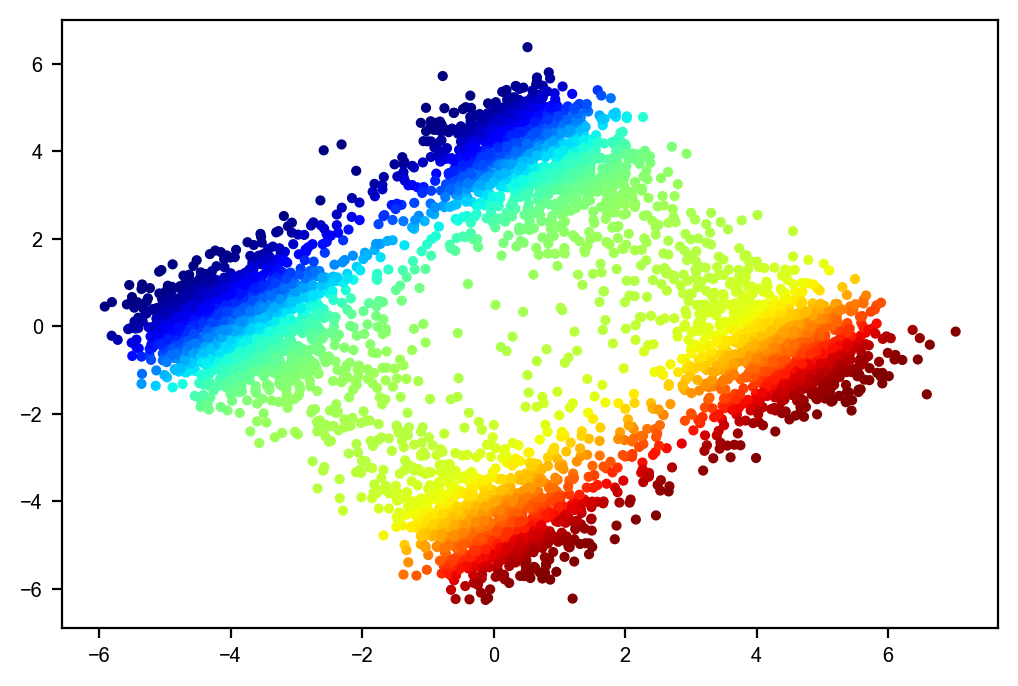

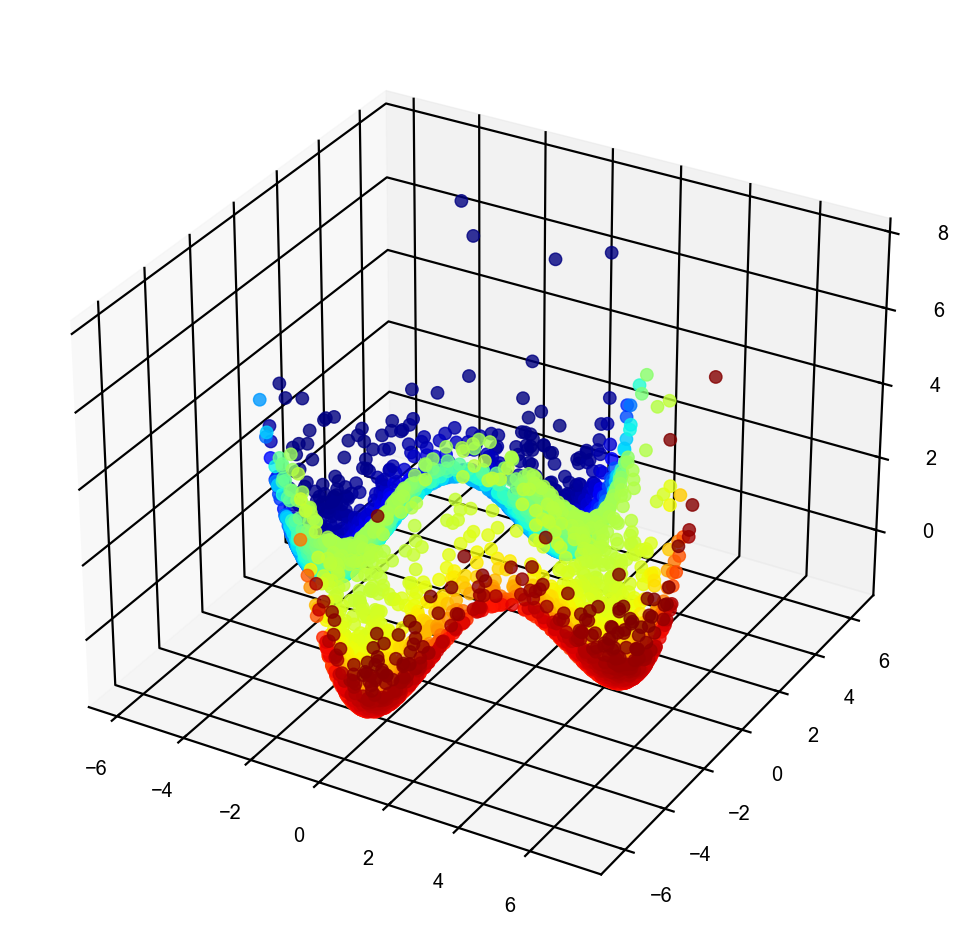

In [119]:
pca=PCA(n_components=3).fit(X)
S_pca=pca.transform(X)
plt.scatter(S_pca[:,0],S_pca[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    S_pca[:, 0],S_pca[:, 1], S_pca[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

In [120]:
epochs = 200
nsamples = 3
learning_rate = 1e-3
seed = 1987
n_workers = 0
K =3
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset

if seed is not None:
    reset_seeds(seed)

A=A.astype(np.float32)
X=X.astype(np.float32)
z=color_label

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

L = 3
encoder = Encoder(X.shape[1], L)

In [121]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = 200#epochs // n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [122]:
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

0 tensor(1.6034e+09, grad_fn=<DivBackward0>)
10 tensor(7.5681e+08, grad_fn=<DivBackward0>)
20 tensor(6.8850e+08, grad_fn=<DivBackward0>)
30 tensor(6.6511e+08, grad_fn=<DivBackward0>)
40 tensor(6.5342e+08, grad_fn=<DivBackward0>)
50 tensor(6.3826e+08, grad_fn=<DivBackward0>)
60 tensor(6.3916e+08, grad_fn=<DivBackward0>)
70 tensor(6.4774e+08, grad_fn=<DivBackward0>)
80 tensor(6.3343e+08, grad_fn=<DivBackward0>)
90 tensor(6.3551e+08, grad_fn=<DivBackward0>)
100 tensor(6.4104e+08, grad_fn=<DivBackward0>)
110 tensor(6.2892e+08, grad_fn=<DivBackward0>)
120 tensor(6.4047e+08, grad_fn=<DivBackward0>)
130 tensor(6.2241e+08, grad_fn=<DivBackward0>)
140 tensor(6.3105e+08, grad_fn=<DivBackward0>)
150 tensor(6.3482e+08, grad_fn=<DivBackward0>)
160 tensor(6.3191e+08, grad_fn=<DivBackward0>)
170 tensor(6.3015e+08, grad_fn=<DivBackward0>)
180 tensor(6.2262e+08, grad_fn=<DivBackward0>)
190 tensor(6.4395e+08, grad_fn=<DivBackward0>)


In [123]:
z=train_data.z
mu, sigma = encoder(train_data.X)
mu_learned = mu.detach().numpy()
sigma_learned = np.sqrt(sigma.detach().numpy())#The learned sigma is variance

In [124]:
sort_idx = z.argsort()

match_idx=sort_idx[np.searchsorted(z,color_label,sorter = sort_idx)]
print(match_idx)

[4049  816 4061 ... 2551 4794 1104]


In [125]:
X_mu=mu_learned[match_idx]
X_sigma=sigma_learned[match_idx]
X_label=z[match_idx]

In [126]:
latent_z=[]
for i in range(X_mu.shape[1]):
    latent_z.append(X_mu[:,i])
    latent_z.append(X_sigma[:,i])
latent_z=np.array(latent_z).T
latent_z.shape

(5000, 6)

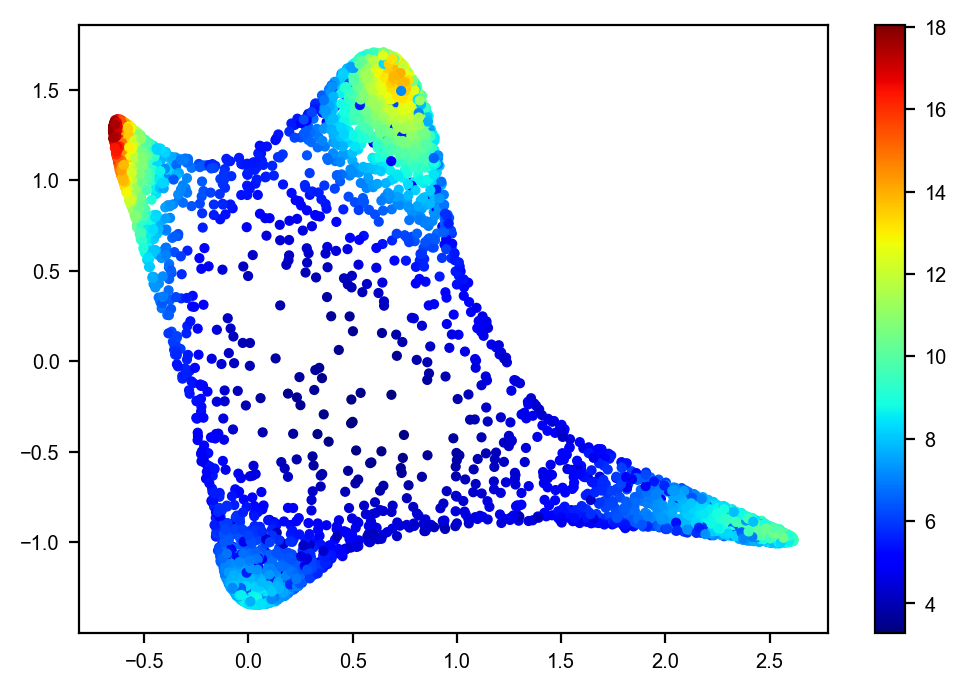

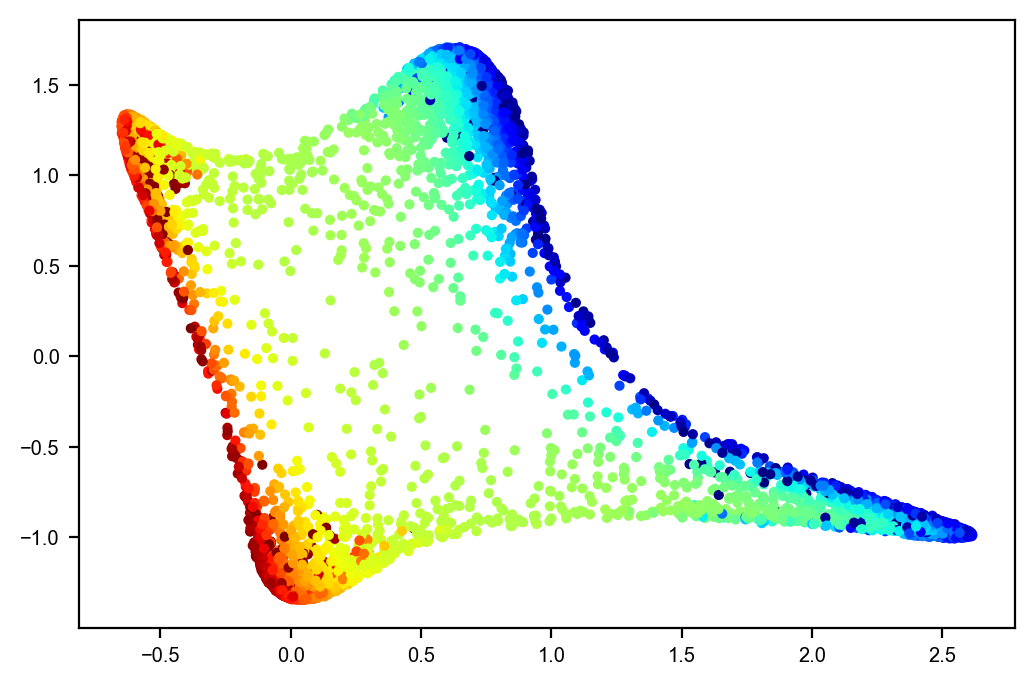

In [127]:
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=np.sum(1/X_sigma**2,axis=1),cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=X_label,cmap=plt.cm.jet)
plt.show()


In [128]:
Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,2*j,2*j]=1/(X_sigma[i,j]**2)
        Fisher_g[i,2*j+1,2*j+1]=2/(X_sigma[i,j]**2)

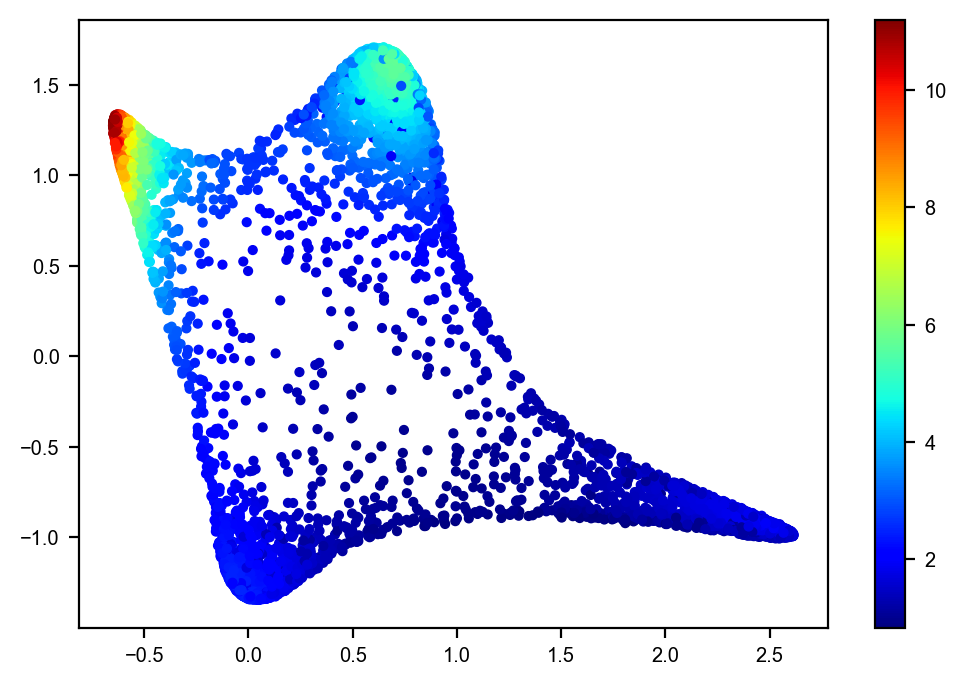

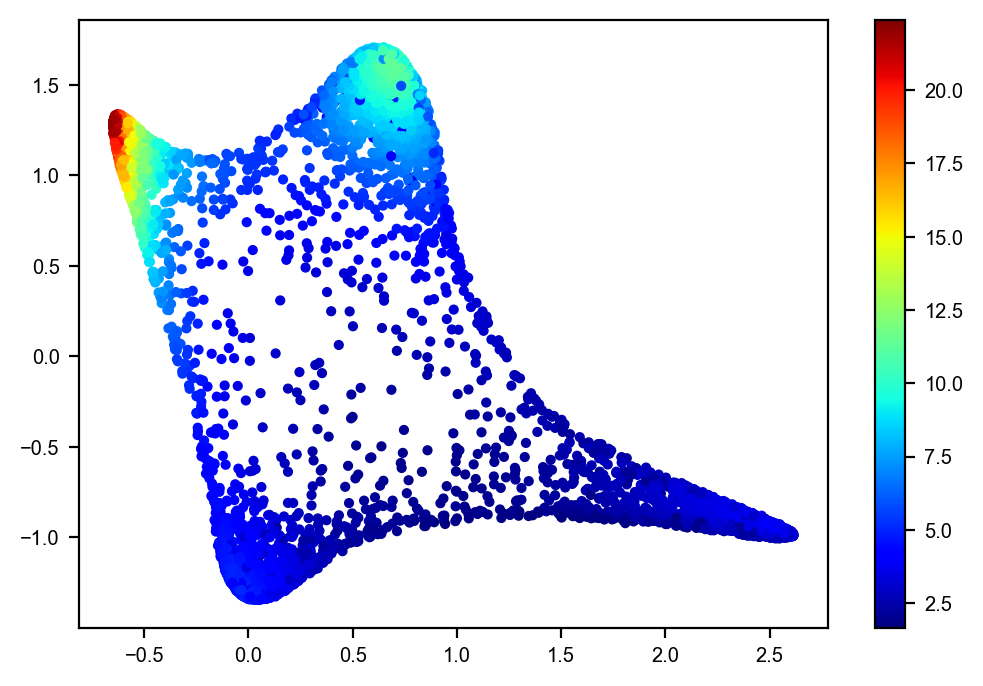

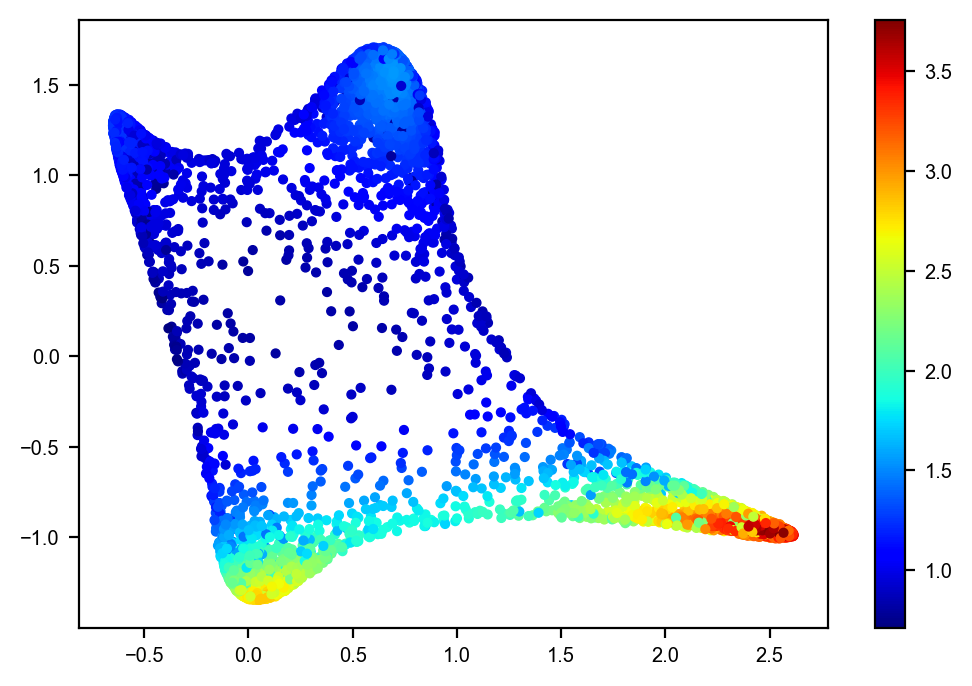

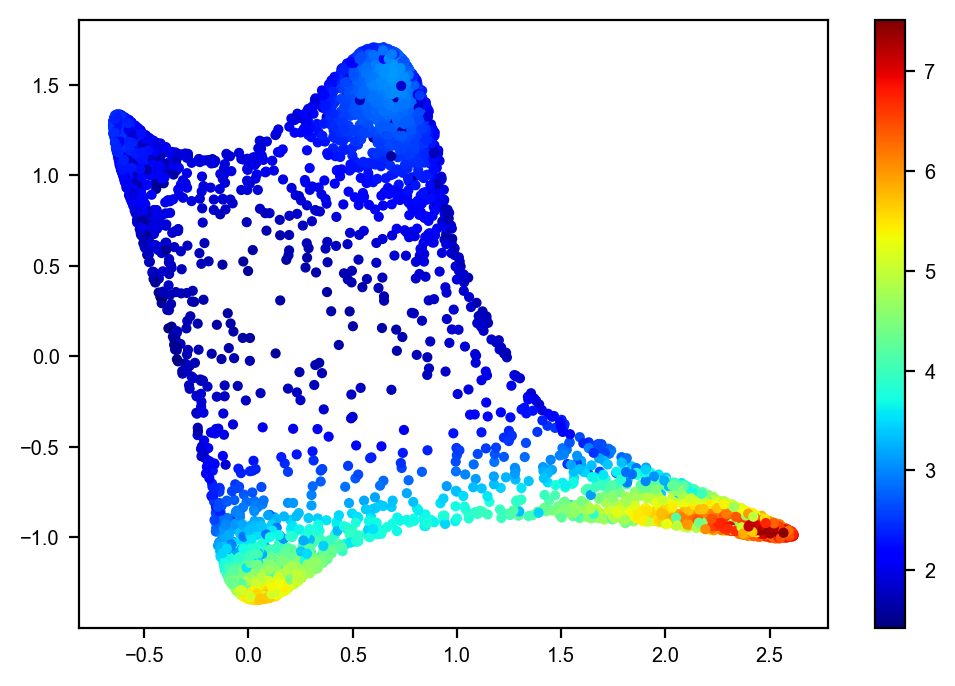

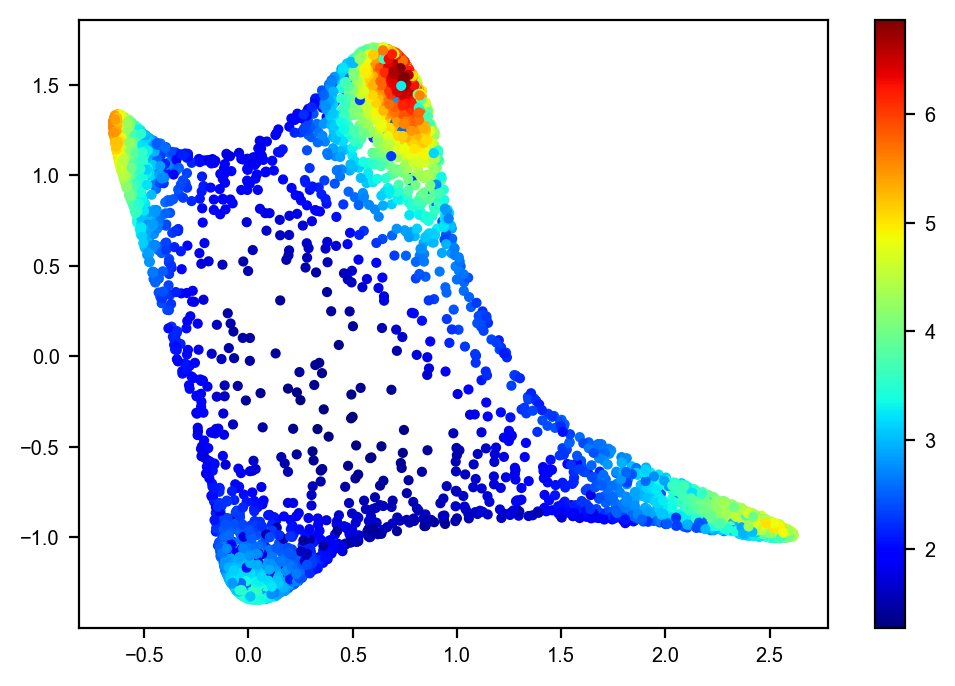

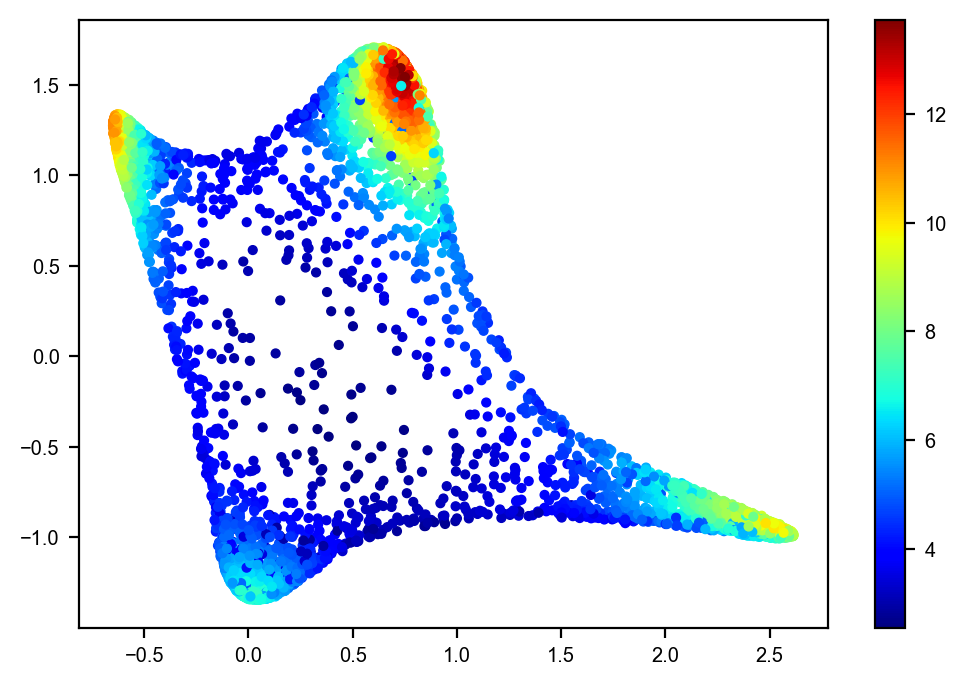

In [129]:
for j in range(L*2):

    plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=Fisher_g[:,j,j],cmap=plt.cm.jet)
    plt.colorbar()
    plt.show()

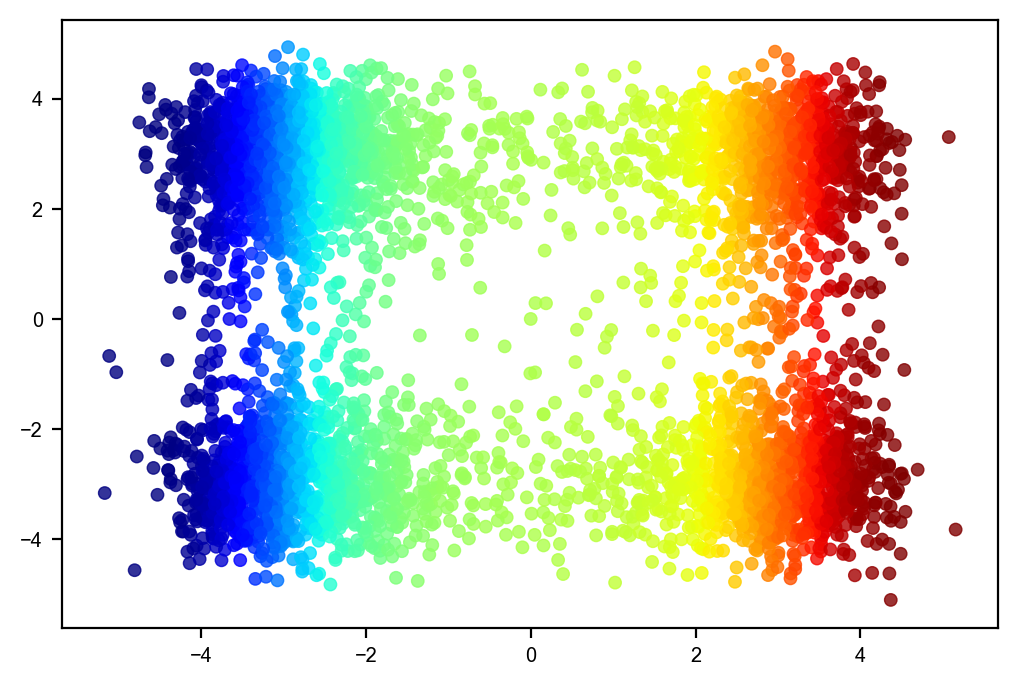

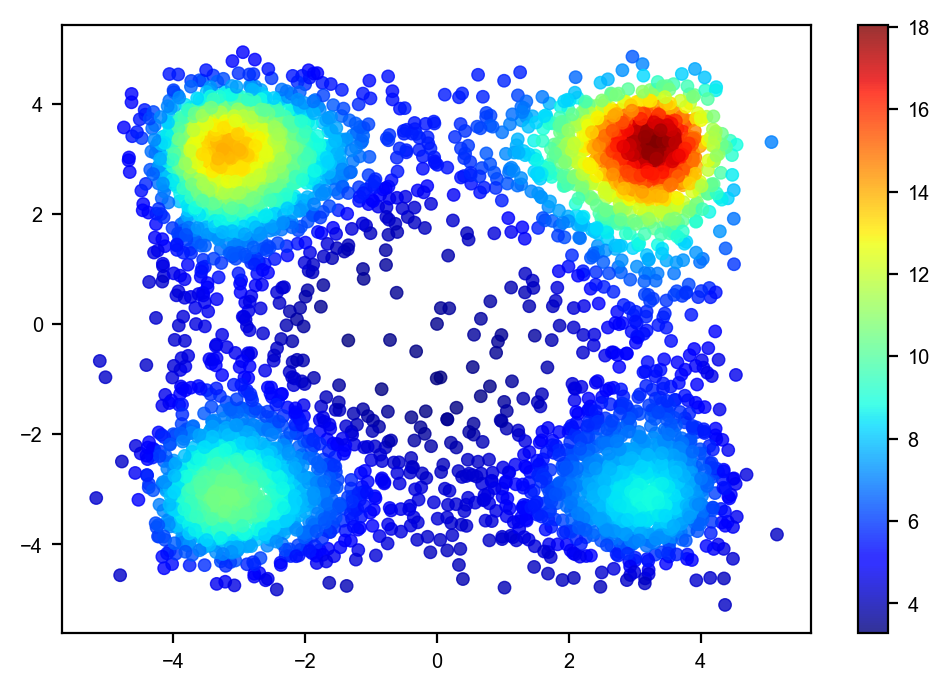

In [130]:
plt.scatter(X[:, 0],X[:, 1], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.show()


plt.scatter(X[:, 0],X[:, 1], c=np.sum(1/X_sigma**2,axis=1), s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [131]:
def Fisher_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dF2=0
    for i in range(dim):
        a=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)+\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        b=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)-\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        
        dF2+=2*(np.log(a/b))**2
    dF=np.sqrt(dF2)
    return dF

In [132]:
def KL_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    KL_dist=0
    for i in range(dim):
        #the after KL_12+KL_21 the log(det(sigma1)/det(sigma2))+log(det(sigma2)/det(sigma1))=0
        # so do not calculate this term
        KL_12=1/2*(-1+sigma1[i]**2/sigma2[i]**2+dmu[i]**2/sigma2[i]**2)
        KL_21=1/2*(-1+sigma2[i]**2/sigma1[i]**2+dmu[i]**2/sigma1[i]**2)
        KL_sym=KL_12+KL_21
        KL_dist+=KL_sym
    return KL_dist

In [1]:
# #-------------calcualte distance pair--------------
# dist_ratios=[]
# for inds in cell_nei:#np.split(A.indices, A.indptr)[1:-1]:

#     dist_r=[]
#     self_ind=inds[0]
#     for nei_k in range(1,len(inds)):
        
#         dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
#         dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
#                         X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])

#         gau_dEu=np.linalg.norm(X_mu[self_ind,:]-X_mu[inds[nei_k],:])
        
#         dKL=KL_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
#                         X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
#         dist_r.append(dEu/dFi)

        
        
# #     print(np.std(dist_r)/np.mean(dist_r))
    
#     dist_ratios.append(np.std(dist_r)/np.mean(dist_r))

# plt.hist(np.array(dist_ratios),bins=100,edgecolor='black')
# plt.show()

In [134]:
def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2)
    return W_dist

In [135]:
cRc_arr=[]
for inds in cell_nei:#np.split(A.indices, A.indptr)[1:-1]:

    self_ind=inds[0]
    cRc=0
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        dWa=wasserstein_distance(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        cRc+=(1-dWa/dEu)
    
    cRc_arr.append(cRc/len(inds))
#     cRc_arr.append(cRc)
cRc_arr=np.array(cRc_arr)

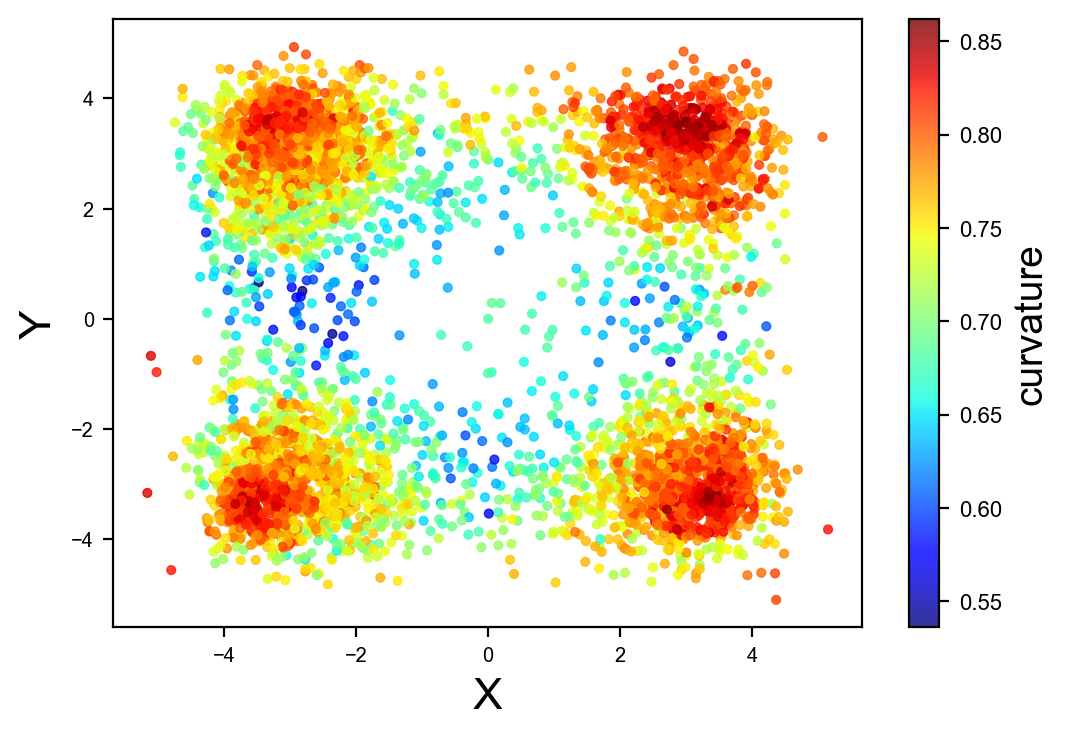

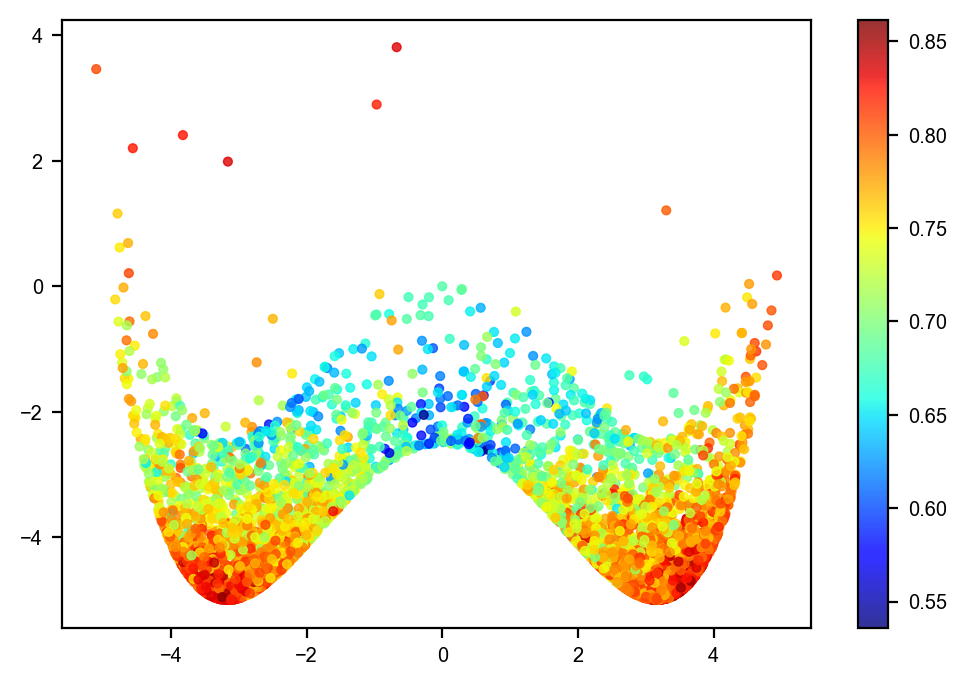

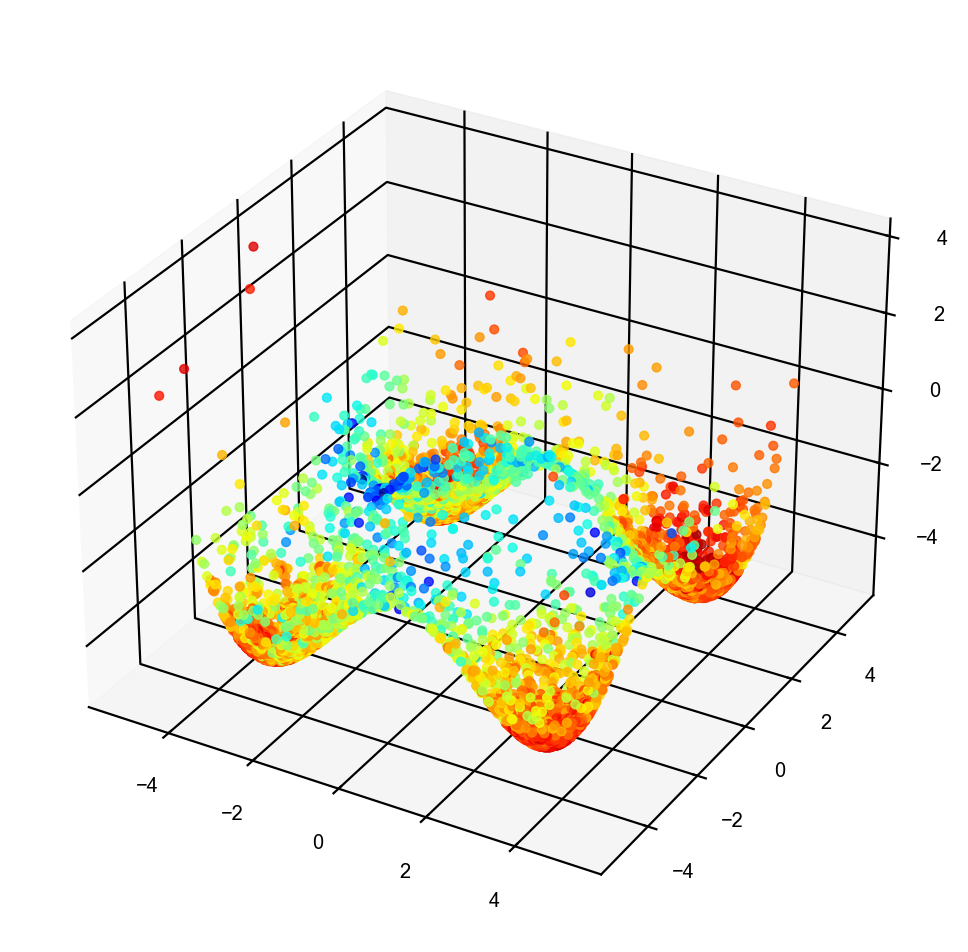

In [136]:
plt.scatter(X[:, 0],X[:, 1], c=cRc_arr, s=10, alpha=0.8,cmap=plt.cm.jet)

clb=plt.colorbar()
clb.ax.tick_params(labelsize=8)
# clb.ax.set_title('curvature',fontsize=16)

clb.ax.set_ylabel('curvature',fontsize=14)

plt.xlabel('X',fontsize=16)
plt.ylabel('Y',fontsize=16)
plt.savefig(result_dir+'4well_cRc.png')
plt.show()

plt.scatter(X[:,1],X[:, 2], c=cRc_arr, s=10, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=cRc_arr, s=10, alpha=0.8,cmap=plt.cm.jet
)
plt.savefig(result_dir+'4well_3D_cRc.png')
plt.show()

In [137]:
def smooth_func(X_val,cell_nei,nei_w):
    X_sm=X_val.copy()
    for ci in range(len(X_val)):
        X_sm[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_sm
cRc_smooth=smooth_func(cRc_arr,cell_nei,nei_w)

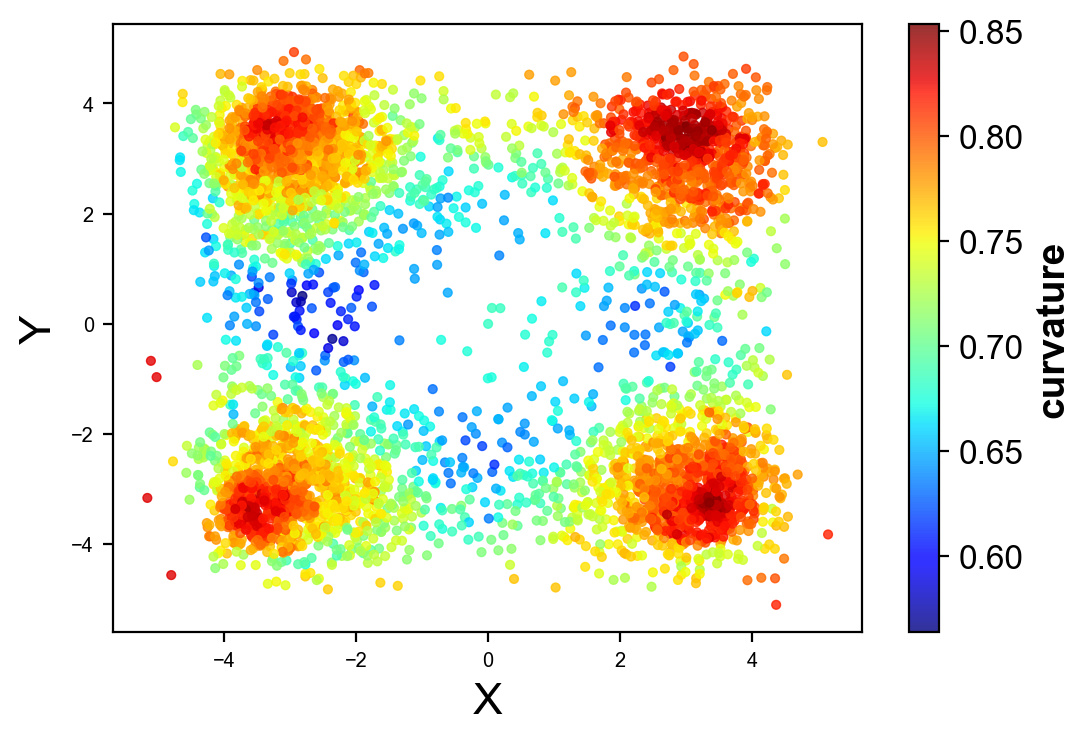

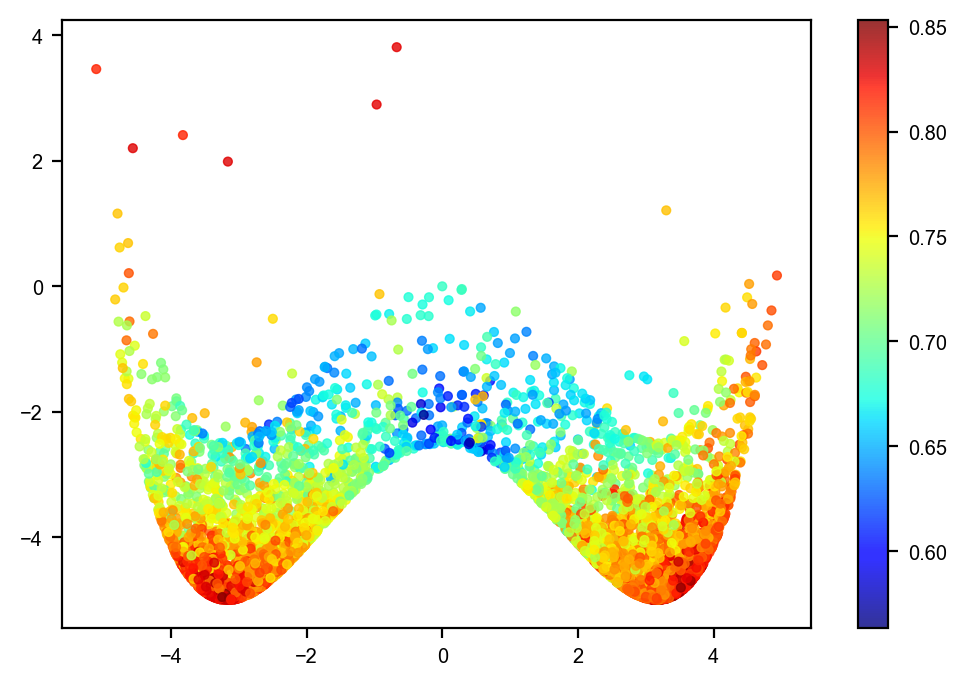

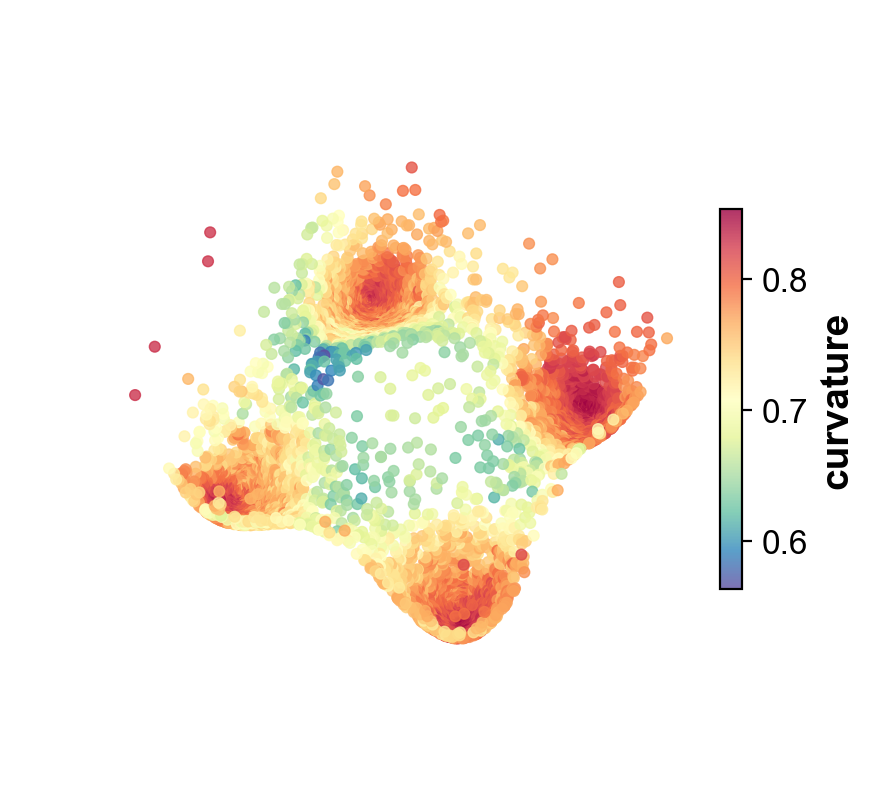

In [145]:
plt.scatter(X[:, 0],X[:, 1], c=cRc_smooth, s=10, alpha=0.8,cmap=plt.cm.jet)

clb=plt.colorbar()
clb.ax.tick_params(labelsize=12)
# clb.ax.set_title('curvature',fontsize=16)

clb.ax.set_ylabel('curvature',fontsize=14,fontweight='bold')

plt.xlabel('X',fontsize=16)
plt.ylabel('Y',fontsize=16)
# plt.axis('off')
plt.savefig(result_dir+'4well_cRc.png',dpi=300)
plt.show()

plt.scatter(X[:,1],X[:, 2], c=cRc_smooth, s=10, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(7.5, 5))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
p=ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=cRc_smooth, s=15, alpha=0.8,cmap=plt.colormaps['Spectral_r']
)
ax.set_axis_off()
# fig.colorbar(p,ax=ax, shrink=0.5)
# clb.ax.set_title('curvature',fontsize=16)

cax = fig.add_axes([ax.get_position().x1-0.04,ax.get_position().y0+\
                    ax.get_position().height/4,0.015,ax.get_position().height/2])

clb=fig.colorbar(p,shrink=0.5,cax=cax)

clb.ax.tick_params(labelsize=12)

clb.ax.set_ylabel('curvature',fontsize=14,fontweight='bold')
# ax.view_init(90,0)
ax.view_init(elev=60,roll=0)#, azim=40, 

plt.savefig(result_dir+'4well_3D_cRc.png',dpi=300)

plt.show()